In [53]:
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
def IDM(para, spacing, svSpd, relSpd):
    # para is a vector containing IDM's parameters
    desiredSpd = para[0] #in m/s
    desiredTimeHdw = para[1] #in seconds
    maxAcc = para[2] # m/s^2
    comfortAcc = para[3] # m/s^2
    beta = para[4]
    jamSpace = para[5] #in meters
    
    desiredSpacing = jamSpace + max(0, desiredTimeHdw*svSpd-svSpd*relSpd/(2*np.sqrt(maxAcc*comfortAcc)))
    acc = maxAcc*(1-(svSpd/desiredSpd)**beta-(desiredSpacing/spacing)**2)
    
    return acc


In [63]:
def IDM_sim(para, event, context = 40):
    # para is a vector containing IDM parameters
    # event is the car following event with columns [spacing, svSpd, relSpd, lvSpd]
    # context is the amount of data used as historical data
    
    T = 0.1 # data sampling interval
    MAX_LEN = 150
    
    svSpd_sim = []
    spacing_sim = []
    
    spacing, svSpd, relSpd = event[context-1][:-1]
    
    lvSpd = event[:, -1]
    
    for i in range(context, MAX_LEN):
        acc = IDM(para, spacing, svSpd, relSpd)

        svSpd_ = max(0.001, svSpd + acc*T) # next step svSpd
        relSpd_ = lvSpd[i] - svSpd_
        
        spacing_ = spacing + T*(relSpd_ + relSpd)/2 
        
        svSpd = svSpd_
        relSpd = relSpd_
        spacing = spacing_
        
        svSpd_sim.append(svSpd)
        spacing_sim.append(spacing)
        
    svSpd_obs = event[context:MAX_LEN, 1]
    spacing_obs = event[context:MAX_LEN:, 0]
    lvSpd_obs = event[context:MAX_LEN, -1]
    
    return svSpd_obs, spacing_obs, lvSpd_obs, svSpd_sim, spacing_sim

In [35]:
root = '/media/meixin/transfollower/data'

val = np.load(os.path.join(root, 'val_SH' + '.npy'), allow_pickle = True)
test = np.load(os.path.join(root, 'test_SH' + '.npy'), allow_pickle = True)

calibration_res = sio.loadmat('IDM/IDM_SH_transformer.mat')
para = calibration_res['bestX'][0]
print('IDM para:', para)

IDM para: [32.0489077   0.74084102  1.18623382  0.87773747  1.          2.95210611]


Text(0, 0.5, 'Spacing (m)')

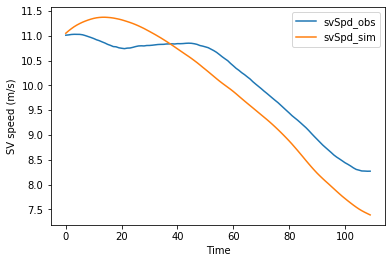

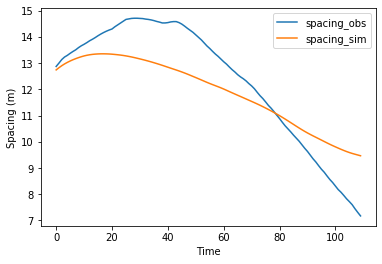

In [67]:
event = data[0]

svSpd_obs, spacing_obs, lvSpd_obs, svSpd_sim, spacing_sim = IDM_sim(para, event)

plt.figure()
plt.plot(svSpd_obs, label = 'svSpd_obs')
plt.plot(svSpd_sim, label = 'svSpd_sim')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SV speed (m/s)')

plt.figure()
plt.plot(spacing_obs, label = 'spacing_obs')
plt.plot(spacing_sim, label = 'spacing_sim')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Spacing (m)')

## Calculate MSE on val and test dataset

In [65]:
def mse_calculate(data):
    
    MSEs = []
    for event in data:
        svSpd_obs, spacing_obs, lvSpd_obs, svSpd_sim, spacing_sim = IDM_sim(para, event)
        assert np.isnan(svSpd_obs).sum() == 0
        assert np.isnan(spacing_obs).sum() == 0
        
        MSE = np.mean((svSpd_obs - svSpd_sim)**2) + np.mean((spacing_obs - spacing_sim)**2)
        
        MSEs.append(MSE)
    
    return np.mean(MSEs)

In [66]:
mse_calculate(val), mse_calculate(test)

(21.63735462129142, 22.547545060772467)